In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import keras_tuner as kt
import numpy as np
import networkx as nx
import funcy as fy
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import mlflow

import usgoc.preprocessing.graph.wl2 as wl2
import usgoc.datasets.unsafe_go as dataset
import usgoc.models.gnn as gnn
import usgoc.evaluation.models as em
import usgoc.utils as utils
import usgoc.metrics.multi as mm
import usgoc.evaluation.evaluate as ee
import usgoc.postprocessing.explain as explain

In [13]:
fold = 2
# mode = "split_blocks"
mode = "atomic_blocks"
limit_id = "v127_d127_f127_p127_core"
limit_id = "v0_d0_f0_p0_no_v_vt_bt_tf_fb"  # "datatype_flag" important!
limit_id = "v0_d0_f0_p0_no_v_vt_bt_tf_fb_ob"  # "ob" important!
limit_id = "v0_d0_f0_p0_no_v_vt"
limit_id = "v0_d127_f0_p0_core"
limit_id = "v127_d127_f127_p127"
limit_id = "v0_d0_f0_p0_no_v_vt_bt_tf_fb_ob_ou_s"  #
limit_id = "v0_d0_f0_p0_no_v_vt_bt_fb_ob_ou_s"  #
limit_id = dict(
    varname=0, datatype=0, function=0, package=0,
    type={"block", "subblock"},
    # type={"block", "subblock", "var"},
    blocktype=False, selfref=False, vartype=False,
    # datatype_flag={"Basic", "Interface", "Named", "Pointer"},
    # datatype_flag=True,
    datatype_flag=False,
    builtin_function=False,
    binary_op=False, unary_op=False,
    only_core_packages=False
)
limit_name = dataset.get_limit_name(limit_id)
limit_id = "v127_d127_f127_p127"
batch_size_limit = 200

limit_name

with utils.cache_env(use_cache=True):
  files = dataset.load_filenames()
  raw = dataset.load_raw()
  ds = dataset.load_dataset(mode=mode)
  graphs, targets = ds
  full_dims = dataset.create_graph_dims(graphs, mode=mode)

# files[683]
# files.index("/app/raw/unsafe-go-dataset/app/efficiency__cast-pointer/efb20d96d7e6d3b08653.json")
# with utils.cache_env(use_cache=True): gs = dataset.raw_to_graphs(raw, mode=mode)
# g = gs[683]; print(g.source_code)
# utils.draw_graph(g, layout="dot")
# [k for k in g.types_to_pkgs.keys()]
# g.types_to_pkgs
# h = dataset.collect_node_label_histogram(gs, mode=mode)
# [k for k, v in h["core_datatype"].items() if not v]

# graphs[0].nodes[4]
# utils.draw_graph(graphs[0], layout="dot")

# len(dataset.get_dim_limit_dict().keys())

# dataset.get_dim_limit_dict()[limit_id]

# -%%

with utils.cache_env(use_cache=True):
  splits = dataset.get_split_idxs(ds)
  labels1, labels2 = dataset.create_target_label_dims(ds)
  labels1_keys = labels1.keys()
  labels2_keys = labels2.keys()
  labels1_inv = fy.flip(labels1)
  labels2_inv = fy.flip(labels2)

# model = gnn.MLP
# model = gnn.DeepSets
# model = gnn.GCN
# model = gnn.GIN
# model = gnn.GGNN
# model = gnn.RGCN
model = gnn.WL2GNN

# model1 = em.DeepSetsBuilder
# model = em.GGNNBuilder

# with utils.cache_env(use_cache=True):
#   dims, train_ds, val_ds, test_ds = dataset.get_encoded_dataset_slices(
#       ds, model.in_enc, splits, fold, limit_id=limit_id, mode=mode,
#       batch_size_limit=batch_size_limit)
#   train_ds = train_ds.cache()
#   val_ds = val_ds.cache()
#   train_slice, val_slice, test_slice = dataset.get_dataset_slices(
#       ds, splits, fold)

In [47]:
dots = [nx.nx_agraph.to_agraph(g).to_string() for g in graphs]
with open("/app/results/graphs_dot.json", "w") as f:
  json.dump(dots, f)

In [ ]:
def time_str():
  return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


def experiment(model, epochs=150, log=True):
  if isinstance(model, kt.HyperModel):
    tuner = kt.Hyperband(
        model,
        objective="val_accuracy",
        max_epochs=200, factor=3,
        hyperband_iterations=1,
        directory=f"{utils.PROJECT_ROOT}/evaluations",
        project_name=f"playground_{model.name}")
    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=30)
    tuner.search(
        train_ds, validation_data=val_ds, verbose=2, epochs=500,
        callbacks=[stop_early])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best HPs:", best_hps)
    m = tuner.hypermodel.build(best_hps)
    patient_stop_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=100, restore_best_weights=True)
    m.fit(
        train_ds, validation_data=val_ds, verbose=2, epochs=1000,
        callbacks=[patient_stop_early])
    res = m.evaluate(test_ds, return_dict=True)
    print(res)
    return m
  else:
    m = model(
        node_label_count=dims["node_label_count"],
        conv_directed=True,
        # conv_reverse=False,
        conv_layer_units=[400] * 4, fc_layer_units=[200] * 2,
        conv_activation="tanh",
        conv_inner_activation="elu",
        fc_activation="tanh",
        pooling="min",
        # For 2-WL-GNN:
        # conv_activation="tanh",
        # conv_inner_activation="tanh",
        # fc_activation="elu",
        # pooling="mean",
        #
        # conv_dropout_rate=0.1,
        # fc_dropout_rate=0.2,
        conv_batch_norm=True,
        fc_batch_norm=True,
        out_activation=None,
        learning_rate=0.001)

    tb = tf.keras.callbacks.TensorBoard(
        log_dir=f"/app/logs/{time_str()}_{model.name}_{limit_name}_fold{fold}",
        histogram_freq=10,
        embeddings_freq=10,
        write_graph=True,
        update_freq="batch")
    patient_stop_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=100, restore_best_weights=True)
    m.fit(
        train_ds, validation_data=val_ds, verbose=2, epochs=epochs,
        callbacks=[tb, patient_stop_early] if log else [patient_stop_early])
    res = m.evaluate(test_ds, return_dict=True)
    print(res)
    return m


In [14]:
# mm._groups = dict()
# m = experiment(model1)
# m.save(f"{utils.PROJECT_ROOT}/logs/test")
# m2 = tf.keras.models.load_model(f"{utils.PROJECT_ROOT}/logs/test", custom_objects=dict(SparseMultiAccuracy=mm.SparseMultiAccuracy))

tf.keras.backend.clear_session()
folds = ee.evaluate(model.name, convert_mode=mode,
  limit_id=limit_id, repeat=0, dry=True,
  return_models=True, return_calibration_configs=True, return_ds=True)
# m[0][2].evaluate(test_ds, return
# m = experiment(model1)

# m2 = experiment(model)

Opening experiment WL2GNN...
Starting outer usgo_v1/atomic_blocks/v127_d127_f127_p127 for WL2GNN...
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold0_repeat0, WL2GNN. Existing run: 3857c336318349e6a94107db726ecfe1.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold1_repeat0, WL2GNN. Existing run: 6f208085debc47bc849a2ab17adf06ba.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold2_repeat0, WL2GNN. Existing run: 64ca1972490646778341b633b8b0840f.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold3_repeat0, WL2GNN. Existing run: 303894f4ff3842b5b94acb890e93fb08.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold4_repeat0, WL2GNN. Existing run: 03c9564ac9d44bb6a1c4a5689a9e728d.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold5_repeat0, WL2GNN. Existing run: 5d6f5c51df174759aff05d40efa6fee0.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_p127_fold6_repeat0, WL2GNN. Existing run: aef422dddbe44d15aedf57dd73edf38e.
Skipping usgo_v1/atomic_blocks_v127_d127_f127_

In [15]:

import usgoc.utils as utils
import usgoc.models.utils as mu
import usgoc.metrics.correlation as corr
import json

labels1_keys = list(labels1.keys())
labels2_keys = list(labels2.keys())
alpha = 0.1

idxs = []
sets1 = []
sets2 = []
preds1 = []
preds2 = []
sizes1 = []
sizes2 = []
fimps1 = []
fimps2 = []

def importance_score_dict(fimps, dim_names, labels, k=10):
  fimps_idx = np.argsort(fimps, axis=1)
  if k > 0 and k < dim_names.shape[0] / 2:
    fimps_idx = np.concatenate([
      fimps_idx[:, :k],
      fimps_idx[:, -k:]
    ], axis=1)

  res = dict()
  for lbl, lbl_fimps, idx in zip(labels, fimps, fimps_idx):
    lbl_dim_names_sorted = dim_names[idx][::-1]
    lbl_fimps_sorted = lbl_fimps[idx][::-1]
    res[lbl] = [
      dict(feature=n, importance=imp)
      for n, imp in zip(lbl_dim_names_sorted, lbl_fimps_sorted)]

  return res

def importance_score_dicts(model, ds, dims, labels1, labels2, k=3):
  fimps1, fimps2 = explain.compute_importances(model, ds)
  dim_names = np.array(dataset.dims_to_labels(dims, dims["in_enc"]))
  n = fimps1.shape[1]
  ds1, ds2 = [], []
  for i in range(n):
    d1 = importance_score_dict(fimps1[:,i,:], dim_names, labels1, k)
    d2 = importance_score_dict(fimps2[:,i,:], dim_names, labels2, k)
    ds1.append(d1)
    ds2.append(d2)
  return ds1, ds2

for (m, cc, dims, train, val, test), split in zip(folds, splits):
  test_idxs = split["test"]
  idxs.append(test_idxs)
  s1, s2, p1, p2 = mu.predict_conformal(m, test, with_preds=True, **cc[alpha])
  i1, i2 = importance_score_dicts(
    m, test, {**dims, "in_enc": model.in_enc}, labels1_keys, labels2_keys)
  fimps1 += i1
  fimps2 += i2
  sets1 += s1
  sets2 += s2
  preds1.append(tf.nn.softmax(p1).numpy())
  preds2.append(tf.nn.softmax(p2).numpy())
  sizes1.append(np.array([len(s) for s in s1], dtype=np.int32))
  sizes2.append(np.array([len(s) for s in s2], dtype=np.int32))

sizes1 = np.concatenate(sizes1, 0)
sizes2 = np.concatenate(sizes2, 0)
sizes = sizes1 + sizes2
sort_idxs = np.argsort(sizes)[::-1]
sizes = sizes[sort_idxs]
idxs = np.concatenate(idxs, 0)[sort_idxs]
preds1 = np.concatenate(preds1, 0)[sort_idxs]
preds2 = np.concatenate(preds2, 0)[sort_idxs]
sets1 = utils.obj_array(sets1)[sort_idxs]
sets2 = utils.obj_array(sets2)[sort_idxs]
fimps1 = utils.obj_array(fimps1)[sort_idxs]
fimps2 = utils.obj_array(fimps2)[sort_idxs]

res = []

for idx, size, s1, s2, p1, p2, i1, i2 in zip(
  idxs, sizes, sets1, sets2, preds1, preds2, fimps1, fimps2):
  res.append(dict(
    idx=idx,
    size=size,
    conformal_sets=(
      fy.lmap(lambda i: (labels1_keys[i], p1[i]), s1),
      fy.lmap(lambda i: (labels2_keys[i], p2[i]), s2)),
    code=graphs[idx].source_code,
    feature_importance_scores=(i1, i2),
    target=(labels1_keys[targets[0][idx]], labels2_keys[targets[1][idx]])
  ))

with open(f"/app/results/preds_{model.name}.json", "w") as f:
  json.dump(res, f, cls=utils.NumpyEncoder)

In [ ]:
def debug_graph(i=None, file=None, test_j=None, val_j=None, draw=True):
  if i is None:
    if file is not None:
      i = fy.first(fy.filter(
          lambda e: file in e[1], enumerate(files)[0]))
    elif test_j is not None:
      i = splits[fold]["test"][test_j]
    elif val_j is not None:
      i = splits[fold]["validation"][val_j]
  print(graphs[i].source_code)
  print(files[i], labels1_inv[targets[0][i]], labels2_inv[targets[1][i]])
  if draw:
    utils.draw_graph(graphs[i], edge_colors=True, layout="dot")
  return i


def get_singleton_ds(i):
  with utils.cache_env(use_cache=False):
    return dataset.dataset_encoders[model.in_enc](dataset.slice(ds, [i]), dims)


def preds_to_dicts(preds, j):
  prob1 = np.around(tf.nn.softmax(preds[0], -1).numpy()[j], 3)
  prob2 = np.around(tf.nn.softmax(preds[1], -1).numpy()[j], 3)
  d1 = fy.zipdict(labels1_keys, zip(list(prob1), list(preds[0][j])))
  d2 = fy.zipdict(labels2_keys, zip(list(prob2), list(preds[1][j])))
  return d1, d2


def draw_confusion(pred_labels, target_labels, normalize=True):
  m1 = mm.sparse_multi_confusion_matrix(
      tf.constant(target_labels[0], dtype=tf.int32),
      tf.constant(pred_labels[0], dtype=tf.int32)).numpy()
  m2 = mm.sparse_multi_confusion_matrix(
      tf.constant(target_labels[1], dtype=tf.int32),
      tf.constant(pred_labels[1], dtype=tf.int32)).numpy()
  a1 = np.sum(np.diag(m1)) / np.sum(m1)
  a2 = np.sum(np.diag(m2)) / np.sum(m2)
  print("L1-Acc:", a1, "L2-Acc:", a2)
  if normalize:
    m1 = np.around(m1 / np.sum(m1, axis=1, keepdims=True), 2) * 100
    m2 = np.around(m2 / np.sum(m2, axis=1, keepdims=True), 2) * 100
  utils.draw_confusion_matrix(m1.astype(int), labels1_keys)
  utils.draw_confusion_matrix(m2.astype(int), labels2_keys)

In [ ]:
# debug_graph(file="5179906774f18e1f8520", draw=False)
# debug_graph(401)


# interesting i's: 40, 70, 874 (44b41ab329d2624a449e),
# Instances on which both DeepSets and GGNN fail (both labels):
# - 43 (a793d8b779605120ec52) true: cast-basic ffi (short snippet)
# - 79 (836d21cfe55279cd8e46) true: delegate atomic (long snippet)
# - 1236 (27b69b7c042b73cf9275) true: memory-access layout (short/medium snippet)

# Instances on wihich only GGNN fails (but not DeepSets):
# - 84 (b01a05c45ecc95b792c8) true: cast-header types (short/medium)
#   Code:
#   func bytesHash(b []byte, seed uintptr) uintptr {
#	    s := (*slice)(unsafe.Pointer(&b))
#	    return memhash(s.array, seed, uintptr(s.len))
#   }
# - 1015 (39edbcf5d9443fc73e3a) true: pointer-arithmetic serialization (short)
# - 1313 (b54f66ea4c799f26617d) true: cast-struct generics (short)
#   Code: func (h *Header) Int8s() []int8 { return *(*[]int8)(unsafe.Pointer(h)) }
#   DeepSets Preds:
#   ({'cast-basic': (0.544, 13.852097),
#     'cast-bytes': (0.0, -0.26986185),
#     'cast-header': (0.0, -3.9276118),
#     'cast-pointer': (0.455, 13.672801),
#     'cast-struct': (0.001, 7.118796),
#     'definition': (0.0, -37.71391),
#     'delegate': (0.0, -3.9902112),
#     'memory-access': (0.0, -4.7687745),
#     'pointer-arithmetic': (0.0, -17.577158),
#     'syscall': (0.0, -22.886244),
#     'unused': (0.0, -5.127344)},
#    {'atomic': (0.0, -8.450554),
#     'efficiency': (0.001, 3.8338575),
#     'ffi': (0.0, 0.4648861),
#     'generics': (0.994, 10.651982),
#     'hide-escape': (0.0, -19.393679),
#     'layout': (0.0, -3.1287308),
#     'no-gc': (0.0, -17.564428),
#     'reflect': (0.0, 1.974027),
#     'serialization': (0.0, 0.13683213),
#     'types': (0.004, 5.250824),
#     'unused': (0.0, -0.42025906)})
#   GGNN Preds:
#   ({'cast-basic': (0.0, 1.3986396),
#     'cast-bytes': (0.993, 19.658085),
#     'cast-header': (0.0, -14.408668),
#     'cast-pointer': (0.0, 11.910549),
#     'cast-struct': (0.0, 6.641031),
#     'definition': (0.0, -29.842493),
#     'delegate': (0.006, 14.610508),
#     'memory-access': (0.0, 5.646147),
#     'pointer-arithmetic': (0.0, -32.213),
#     'syscall': (0.0, -41.637238),
#     'unused': (0.0, -21.783506)},
#    {'atomic': (0.0, 10.781407),
#     'efficiency': (0.007, 13.999677),
#     'ffi': (0.0, -11.787495),
#     'generics': (0.0, 11.160701),
#     'hide-escape': (0.0, -27.821772),
#     'layout': (0.0, -1.9805977),
#     'no-gc': (0.0, -40.828663),
#     'reflect': (0.0, 3.5758069),
#     'serialization': (0.993, 18.984678),
#     'types': (0.0, -6.821523),
#     'unused': (0.0, -30.649702)})
# - 1393 (a4c0182265f30feaa1f2) true: cast-bytes efficiency
#   Code: func (m *SortedMap) Get(key string) (value interface{}, ok bool) {
#	          return m.trie.Get(*(*[]byte)(unsafe.Pointer(&key)))
#         }

# NOTE: On first, third and last two examples serialization was wrongly predicted by GNN (instead of generics/efficiency). Why? DeepSet correctly detects generic, but not efficiency

# train_pred = m.predict(train_ds)
# train_pred2 = m2.predict(train_ds)
# s_pred = m.predict(test_ds)
# s_pred2 = m2.predict(test_ds)
# s_pred_labels = tf.cast(tf.stack([tf.argmax(s_pred[0], -1), tf.argmax(s_pred[1], -1)], 1), tf.int32)
# s_pred_labels2 = tf.cast(tf.stack([tf.argmax(s_pred2[0], -1), tf.argmax(s_pred2[1], -1)], 1), tf.int32)
# target_labels = tf.stack(list(test_ds)[0][1], 1)
# s_pred
# draw_confusion(train_pred, train_slice[1], True)
# draw_confusion(train_pred2, train_slice[1], True)
# draw_confusion(s_pred, test_slice[1], True)
# draw_confusion(s_pred2, test_slice[1], True)
#
# pred_matches = (s_pred_labels == target_labels).numpy()
# pred_matches2 = (s_pred_labels2 == target_labels).numpy()
# problem_js = np.where(~(pred_matches[:, 0] | pred_matches[:, 1]))[0]
# problem_js2 = np.where(~(pred_matches2[:, 0] | pred_matches2[:, 1]))[0]
# set(problem_js) & set(problem_js2)
# set(problem_js2) - set(problem_js)
# len(problem_js2)
#
# # j = problem_js[4]
# j = 32; i = None
# # i = 84
# i = debug_graph(i=i, test_j=j, draw=True)
# i
# preds_to_dicts(s_pred, j)
# preds_to_dicts(s_pred2, j)
# s_pred_labels2[j]

MLP


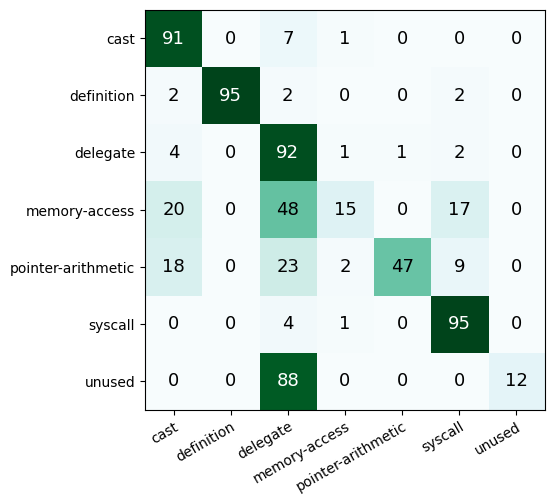

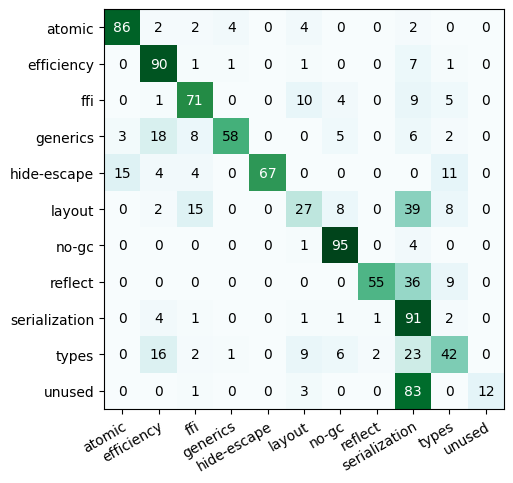

WL2GNN


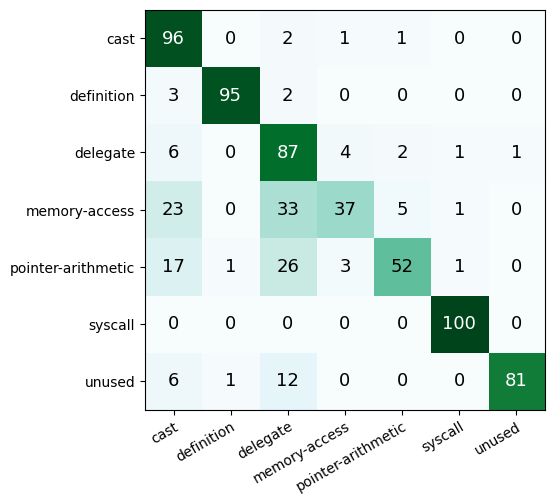

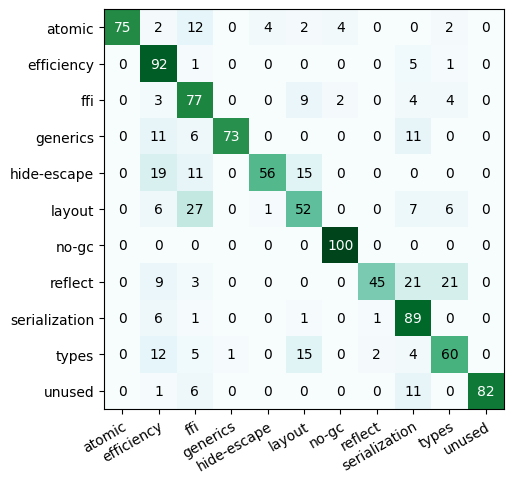

In [69]:
import pickle
import usgoc.evaluation.evaluate as ev

l1_labels = {
		"cast-basic": 0,
		"cast-bytes": 1,
		"cast-header": 2,
		"cast-pointer": 3,
		"cast-struct": 4,
		"definition": 5,
		"delegate": 6,
		"memory-access": 7,
		"pointer-arithmetic": 8,
		"syscall": 9,
		"unused": 10
	}
l2_labels = {
		"atomic": 0,
		"efficiency": 1,
		"ffi": 2,
		"generics": 3,
		"hide-escape": 4,
		"layout": 5,
		"no-gc": 6,
		"reflect": 7,
		"serialization": 8,
		"types": 9,
		"unused": 10
	}

l1_labels = list(l1_labels.keys())
l2_labels = list(l2_labels.keys())

def plot_conf(n):
  with open(f"/app/results/confusion_matrices_raw/atomic_blocks_v127_d127_f127_p127_{n}.pickle", "rb") as f:
    p = pickle.load(f)
  l1, l2 = p[0]["test"], p[1]["test"]

  l1 = np.array(l1)
  l2 = np.array(l2)

  l1 = np.sum(l1, axis=(0, 1))
  l2 = np.sum(l2, axis=(0, 1))

  l1_cast = np.sum(l1[:5,:5])
  l1_cast_row = np.sum(l1[:5,5:], axis=0)
  l1_cast_col = np.sum(l1[5:,:5], axis=1)

  l1_cast, l1_cast_row, l1_cast_col

  l1_contract = np.concatenate([
    np.concatenate([[l1_cast], l1_cast_row]).reshape((1,7)),
    np.concatenate([l1_cast_col.reshape((6,1)), l1[5:,5:]], axis=1)
  ])

  l1_norm_cont = np.around(utils.row_normalize_matrix(l1_contract), 2) * 100
  l2_norm = np.around(utils.row_normalize_matrix(l2), 2) * 100

  print(n)
  fig = utils.draw_confusion_matrix(l1_norm_cont.astype(int), ["cast"] + l1_labels[5:], True, text_config=dict(
    fontsize=13
  ), rotation=30)
  fig.savefig(f"/app/results/confusion_matrices_plot/{n}_compressed_label1.pdf", pad_inches=0, bbox_inches="tight", dpi=300)
  fig = utils.draw_confusion_matrix(l2_norm.astype(int), l2_labels, True, rotation=30)
  fig.savefig(f"/app/results/confusion_matrices_plot/{n}_label2.pdf", pad_inches=0, bbox_inches="tight", dpi=300)


plot_conf("MLP")
plot_conf("WL2GNN")